# Network topology lab

- current lecturer: Sergiu Netotea, Scilifelab, NBIS
- past lecturer: Rui Benfeitas, Scilifelab, NBIS


__Introduction__
In this notebook we will explore how to generate and analyse a multi-omic network comprising metabolites quantifications and gene expression. We will compare these networks against randomly generated networks, and compute different network metrics. At the end we will also perform a community analysis and functional characterization at the gene level.   


## Biological network topology analysis

**Objective**  
In this notebook you will learn how to build and analyse a network built and analysed from a gene-metabolite association analysis. Other mixed networks may also be similarly analyzed, differring only in whether and how you can apply the final functional analysis.

**Data**  
As a test case we will be using the file [met_genes.tsv](met_genes.tsv) which contains abundances for 125 metabolites and 1992 genes, for 24 samples.

**Software**  
This notebook relies on python's igraph for most of the analyses. Most, if not all, functions used here can also be applied with R's igraph. Other packages exist for network analysis including [networkx](https://networkx.github.io/) (which is the default goto for modern datascience) and [graph-tool](https://graph-tool.skewed.de/). [Snap.py](https://snap.stanford.edu/snappy/) is also a good alternative for large networks.

We will build our network through an association analysis, but there are other methods to do this including [Graphical Lasso](http://statweb.stanford.edu/~tibs/ftp/graph.pdf) or [linear SVR](https://papers.nips.cc/paper/1187-support-vector-method-for-function-approximation-regression-estimation-and-signal-processing.pdf).

**Environment**
igraph and gseapy need their own separate python environments, since they do not sit well with the default data science stack. Because of this, the analysis is separated in three parts, each must be run on a specific environments.

**Contents**

- Part 1:
    - > environment: datasci, contains plotting and statistical/ML libraries
    - Data preparation
    - Association analysis
    - Network construction
    - Graph and community study plots (from part 2 and 3)
- Part 2:
    - > environment: igraph, contains graph study and leidenalg based community detection
    - Preliminary analysis
    - Centrality analysis
    - Community detection
- Part 3:
    - > environment: gseapy, annotation studies and basic data processing
    - Functional analysis
    - Conclusion

# Data preparation

You will use a gene expression dataset (RNAseq, expressed as TPM) from a disease group with 24 samples to keep analysis memory and time requirements reasonable for this lesson. It is assumed that all batch effects or other possible technical artifacts are not present, and that all data is ready for analysis. However, there are several important considerations in preprocessing your data:
 - How should you deal with missing values? Should you impute them? How?
 - Should you remove samples based on number of missing values?
 - How should you normalize your data in order to make it comparable throughout?
 
This will depend on the type of that that you have and what you want to do with it, and will severely affect downstream results. It is thus important to carefully think about this.

In [20]:
## Preamble
import itertools, random
import pandas as pd
import numpy as np
import sklearn
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
import pandas as pd

data=pd.read_csv('data/met_genes.tsv', sep="\t", index_col=0)
data.head()

,Type,p10,p11,p12,p14,p15,p16,p18,p22,p23,...,p37,p38,p4,p40,p41,p46,p48,p5,p8,p9
feature,,,,,,,,,,,,,,,,,,,,,
C0_accarnitines,met,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103152,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049757
C2_accarnitines,met,0.007356,0.038454,0.011738,0.011923,0.015104,0.012317,0.021905,0.017777,0.039760,...,0.000000,0.012542,0.018896,0.020212,0.015263,0.012510,0.009677,0.015757,0.010706,0.018615
C3_accarnitines,met,0.000000,0.000000,0.000000,0.000000,0.000888,0.001116,0.001682,0.001024,0.002179,...,0.000000,0.000827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000995
C3DC_C4OH_accarnitines,met,0.000000,0.000000,0.000455,0.001163,0.000000,0.000000,0.000000,0.000000,0.001065,...,0.000000,0.000480,0.000000,0.000717,0.000000,0.000782,0.000398,0.000000,0.000000,0.000312
C5DC_C6OH_accarnitines,met,0.001035,0.001479,0.000430,0.001527,0.000485,0.000792,0.000954,0.000995,0.001356,...,0.005792,0.000400,0.000987,0.001255,0.000885,0.001710,0.000597,0.001218,0.000848,0.000507


No duplicated features are present.

In [3]:
any(data.index.duplicated()) 

False

In [4]:
data.groupby('Type').agg('count')[['p10']] #1992 genes, 125 metabolites

,p10
Type,
genes,1992
met,125


In [5]:
data.shape #2117 features, 25 samples

(2117, 25)

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

# Association analysis

Our initial network analysis will be performed on the association analysis using Spearman correlations. Because this network has a big chance of producing false positives we will consider [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to control for familywise error, as well as [FDR](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure).  

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

In [6]:
values=data.loc[:,data.columns!='Type']
meta=data[['Type']]

In [7]:
values.isna().any().any() #we have no rows with NA

False

We will perform a gene-gene, gene-metabolite, and metabolite-metabolite association analysis by computing pairwise [Spearman correlations](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr). Choosing other non-parametric (Kendall or Spearman) vs parametric (Pearson) methods depends on your data. Here, because we have a small sample size, and want to save on computational time we choose Spearman. 

The following takes a few minutes to run.

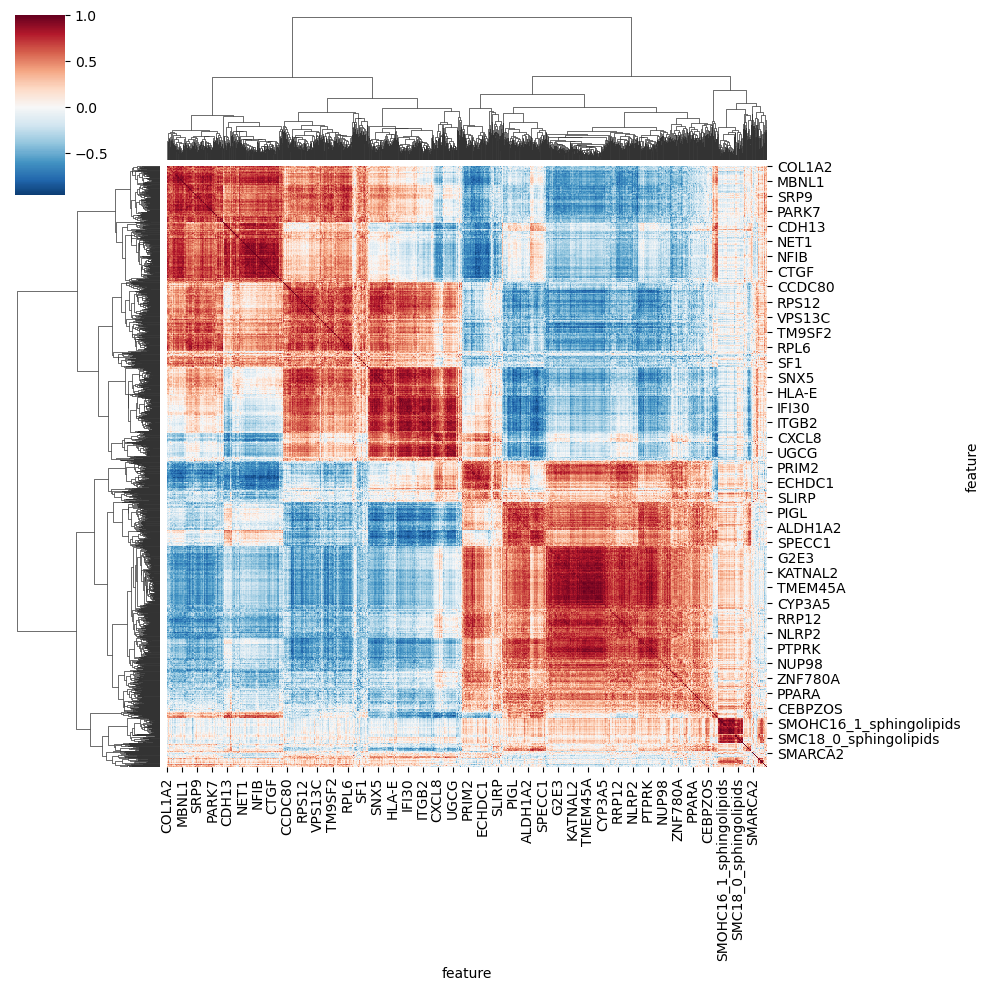

In [8]:
#Correlation and P val matrices
Rmatrix, Pmatrix= sp.stats.spearmanr(values.T)
Rmatrix=pd.DataFrame(Rmatrix, index=values.index.copy(), columns=values.index.copy())

#resulting R matrix
sns.clustermap(Rmatrix, cmap="RdBu_r", center=0); 

If we look at the matrix of P values, we can already see that many of the correlations in the top right columns are not significant even before multiple hypothesis correction:

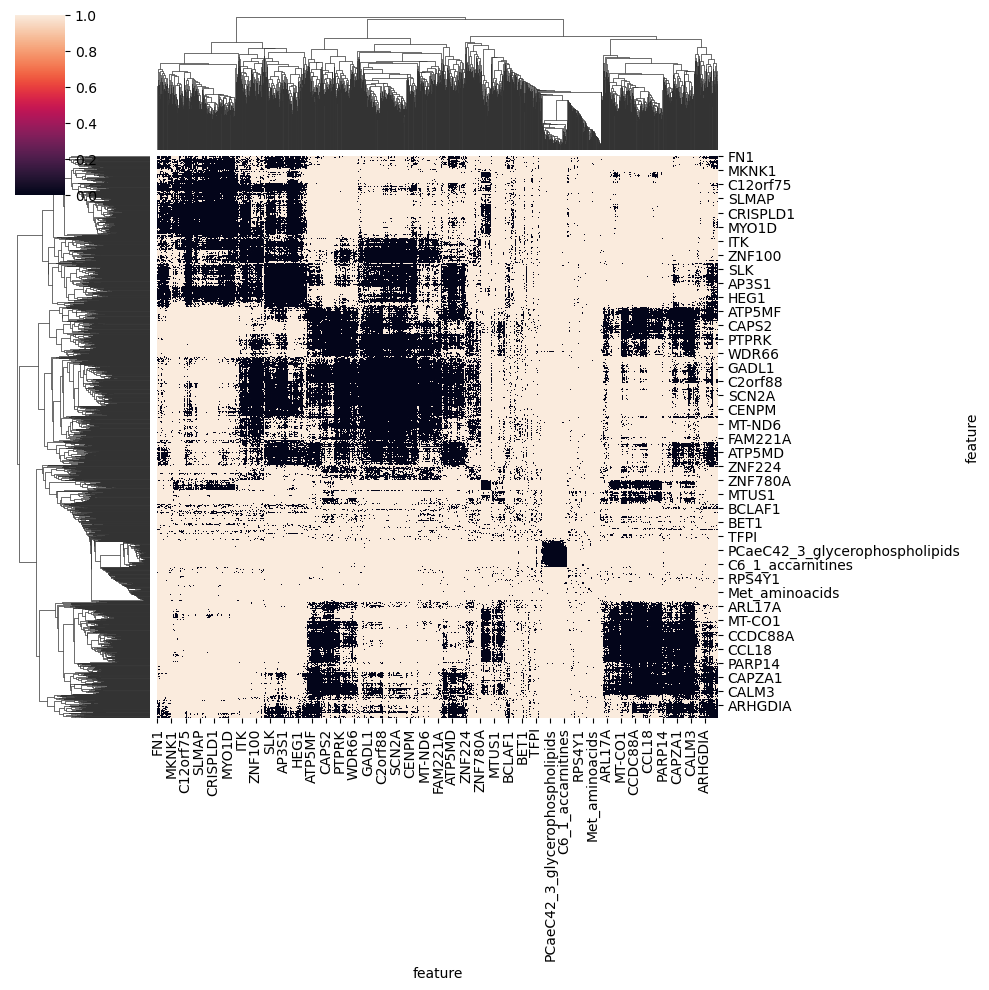

In [9]:
Pmatrix=pd.DataFrame(Pmatrix, index=values.index.copy(), columns=values.index.copy())
changed_Pmatrix=Pmatrix.copy()
changed_Pmatrix[changed_Pmatrix>0.01]=1
#resulting P matrix, similar to that seen in the section above
sns.clustermap(changed_Pmatrix); 

We will now adjust the P values based on the number of comparisons done. The heatmaps above are highlighting a total of $2117^2 \approx 4.5m$ correlations. However, these numbers consider that the same correlation is computed twice (gene A vs gene B, and gene B vs gene A). If we were to include all correlations, we would thus be including many repeated analyses, and we are only interested in half of that above, and excluding the correlation of a feature with itself.   
This means $\frac{2117!}{2!(2117-2)!} \approx 2.2m$ correlations. At an error rate of 0.05, this means that the probability of finding at least one false positive is nearly 100%: $1-0.95^{2000000} \approx 1$. We thus need to correct P values.

In the following cell, we convert the matrix of p*p features to a long matrix, concatenate both R and P for each correlation, and correct based on [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) (`Padj`) and [FDR](https://en.wikipedia.org/wiki/False_discovery_rate) (Benjamin-Hochberg).

In [10]:
#prepare P matrix
Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(bool))
Psquared.columns.name='Feat2'
Pmatrix=Pmatrix.stack()
Pmatrix.index.names=['v1','v2']
Pmatrix=Pmatrix.reset_index()
Pmatrix.columns=['feat1','feat2','P']

In [11]:
#prepare R matrix
Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(bool))
Rmatrix.columns.name='Feat2'
Rmatrix=Rmatrix.stack()
Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
Rmatrix=Rmatrix.reset_index()
Rmatrix.columns=['feat1','feat2','R']

In [12]:
# join both
PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) #Correlation matrix with both R and P
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()

In [13]:
#Multiple hypothesis correction computed on the P column
adjP=pd.DataFrame(multipletests(PRmatrix['P'], method='bonferroni', alpha=0.01)[1], columns=['Padj'])
FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh', alpha=0.01)[1], columns=['FDR'])

PRmatrix=pd.concat([ PRmatrix, adjP], axis=1)
PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)

PRmatrix.head()

,feat1,feat2,R,P,Padj,FDR
0,C0_accarnitines,C2_accarnitines,0.375326,0.070718,1.0,0.149290
1,C0_accarnitines,C3_accarnitines,0.519174,0.009329,1.0,0.033441
2,C0_accarnitines,C3DC_C4OH_accarnitines,0.395363,0.055848,1.0,0.125357
3,C0_accarnitines,C5DC_C6OH_accarnitines,-0.029917,0.889631,1.0,0.928289
4,C0_accarnitines,C5MDC_accarnitines,-0.137801,0.520795,1.0,0.643703


In [14]:
#total number of correlations w/o repetition: 2.2m
PRmatrix.shape[0]

2239786

Considering the Bonferroni correction we find 16305 correlations that are statistically significant at an $\alpha < 0.01$. If we consider instead FDR as correction method, we find 402368, which at a FDR of 0.01 implies $0.01 \times 402368 = 4023$ false positives.

In [15]:
sum(PRmatrix.Padj<0.01)

16305

In [16]:
sum(PRmatrix.FDR<0.01)

402368

Let's add two additional columns, where we assign `R=0` for those correlations that are not statistically significant (`adjP > 0.01`, and `FDR > 0.01`). 

In [ ]:
PRmatrix.loc[:,'R (padj)']=PRmatrix['R'].copy()
PRmatrix.loc[:,'R (fdr)']=PRmatrix['R'].copy()
PRmatrix.loc[PRmatrix['Padj']>0.01,'R (padj)']=0
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0

all_mets=meta.loc[meta.Type=='met'].index
PRmatrix['feat1_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat1 ]
PRmatrix['feat2_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat2 ]
PRmatrix['int_type']=PRmatrix.feat1_type+'_'+PRmatrix.feat2_type

In [19]:
PRmatrix.to_csv('lab/data/serialization/association_matrix.tsv', sep="\t", index=False) #export correlation matrix for faster loading

Now we can see how the initial heatmap of correlations looks. The next cell converts the matrix from long to squared matrix so that we can generate the heatmap. We will plot those features that show statistically significant associations with more than 5% of the features after FDR correction, and compare them between FDR- and Bonferroni-corrected datasets. 

The following plot shows the heatmap of the Spearman rank correlation coefficients after Bonferroni-correction - correlations where Padj > 0.05 are shown as 0.

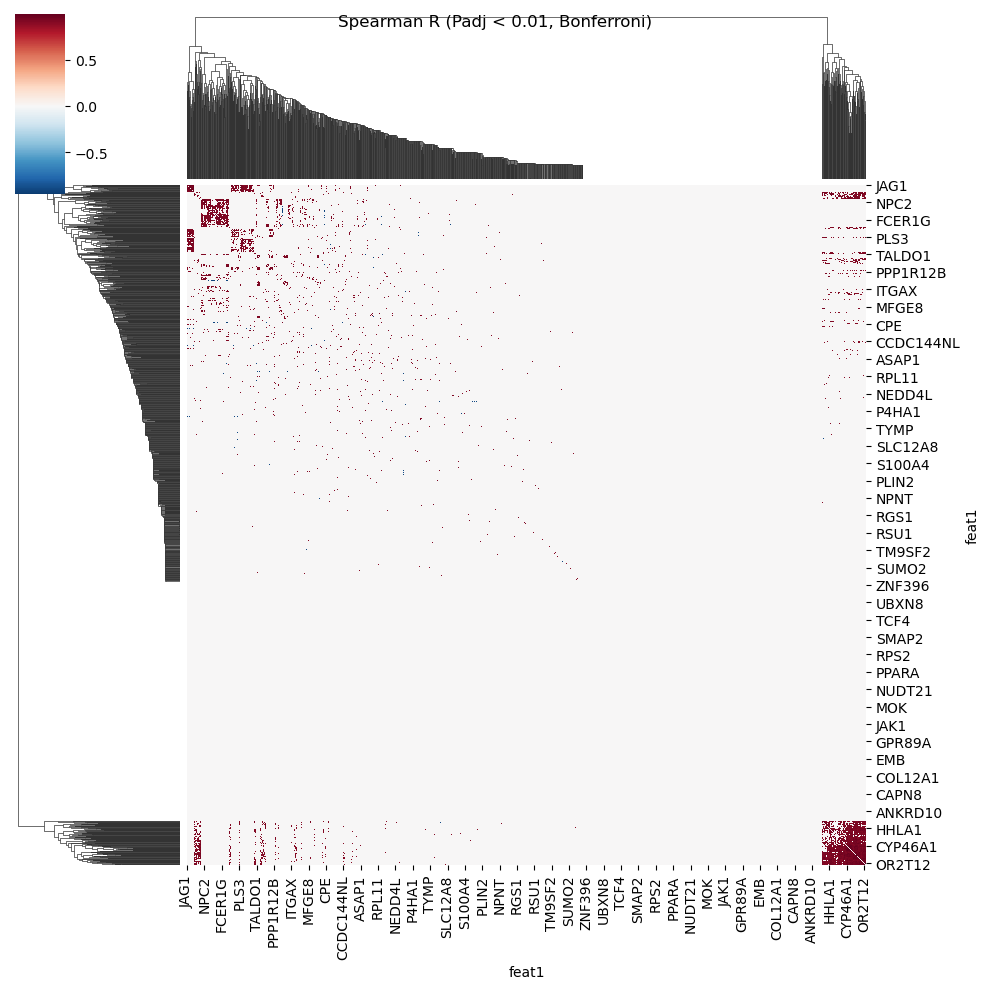

In [20]:
#Transforming to a squared matrix again
PRQ=pd.concat([
    PRmatrix.copy(), 
    PRmatrix.copy().rename(columns={'feat1':'feat2','feat2':'feat1'}).loc[:,PRmatrix.columns]
         ]).drop_duplicates()

Rmatrix_fdr=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (fdr)')
Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.sum()!=0]
Rmatrix_padj=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (padj)')

Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)
Rmatrix_padj=Rmatrix_padj.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)


#Showing only the top correlated features
top_features=Rmatrix_fdr.index[(Rmatrix_fdr!=0).sum()>0.05*Rmatrix_fdr.shape[0]] #top features based on FDR
Rmatrix_fdr_top=Rmatrix_fdr.copy().loc[top_features,top_features] #subsetting R (fdr corrected) matrix
Rmatrix_padj_top=Rmatrix_padj.copy().loc[top_features,top_features] #subsetting R (bonferroni corrected) matrix

g=sns.clustermap(Rmatrix_padj_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (Padj < 0.01, Bonferroni)');


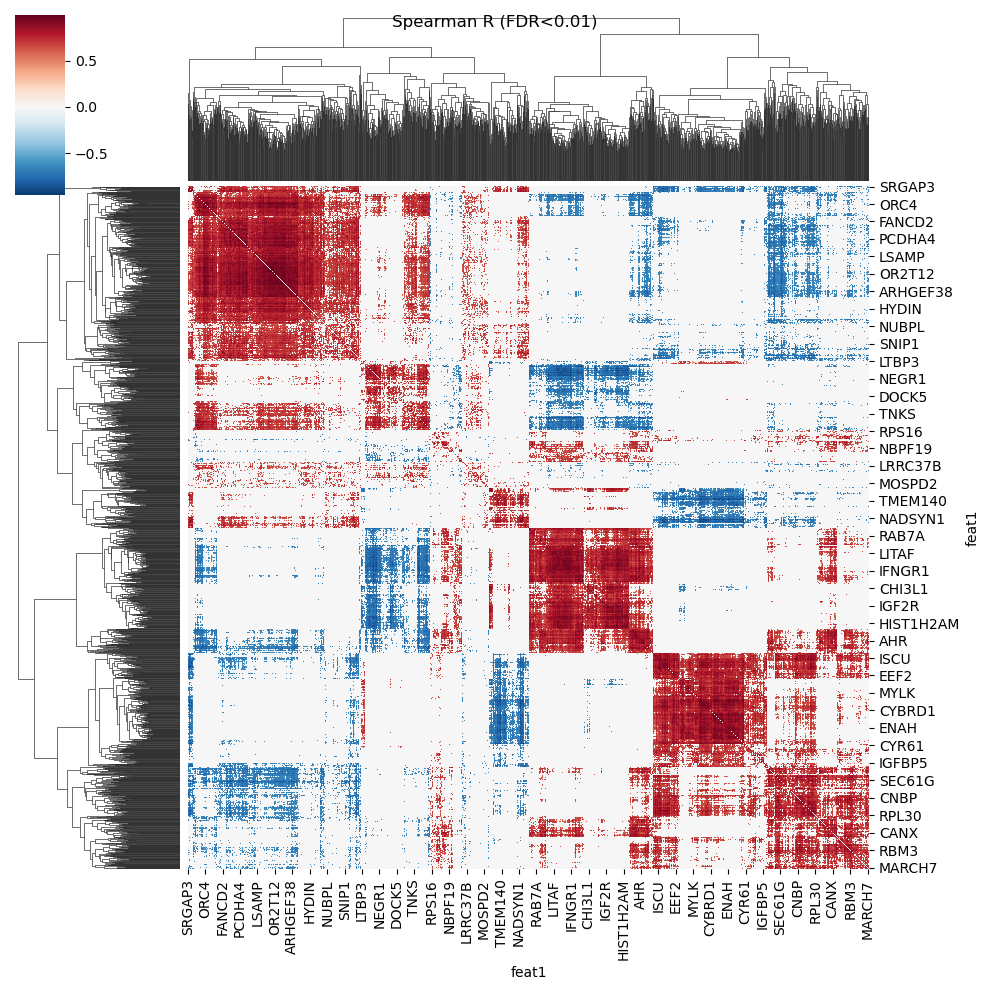

In [21]:
g=sns.clustermap(Rmatrix_fdr_top, cmap="RdBu_r", center=0);
g.fig.suptitle('Spearman R (FDR<0.01)');

The plots above show that the Bonferroni correction is only selecting very high (absolute) correlations. This should remove false positives, but it may also remove weaker correlations that are biologically relevant and true positives. The Bonferroni correction also removes most of the negatively-associated features. Notice this from the distribution of correlation coefficients:

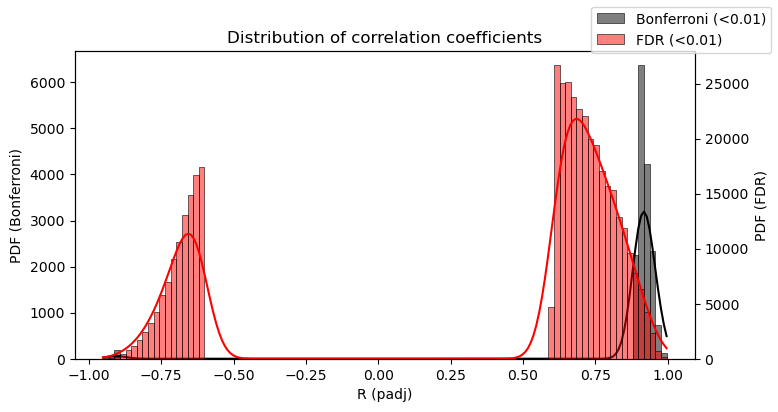

In [26]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R (padj)','R (fdr)']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
p=sns.histplot(shortPR['R (padj)'][shortPR['R (padj)']!=0], color='black', label='Bonferroni (<0.01)', kde=True, bins=100);
p.set(ylabel='PDF (Bonferroni)')
ax2=p.twinx()
g=sns.histplot(shortPR['R (fdr)'][shortPR['R (fdr)']!=0], ax=ax2, color='red', label='FDR (<0.01)', kde=True, bins=100);
g.set(ylabel='PDF (FDR)')

fig.legend()
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
plt.show()

We can also observe that the Bonferroni correction yields a more homogeneous number of associated features for each feature (i.e. first neighbors), compared to the FDR filtering. This has a consequence on the network structure.

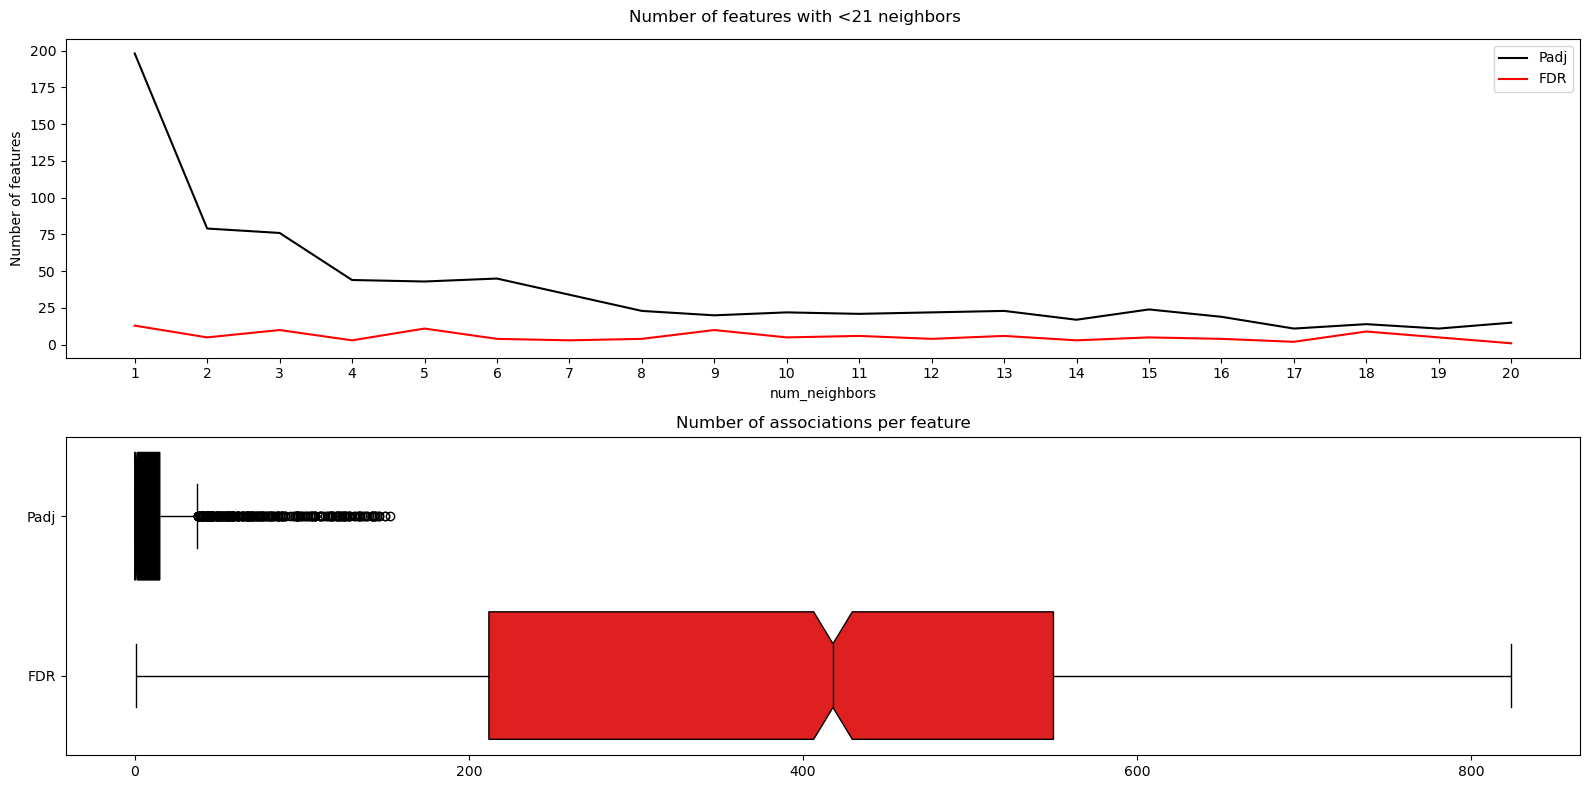

In [27]:
neighbor_number=pd.DataFrame()
for n_neighbors in np.arange(1,21):
    padj_count=((Rmatrix_padj!=0).sum()==n_neighbors).sum()
    fdr_count=((Rmatrix_fdr!=0).sum()==n_neighbors).sum()
    
    out=pd.Series([padj_count, fdr_count], index=['num_features(Padj)','num_features(FDR)'], name=n_neighbors)
    #neighbor_number=pd.concat([neighbor_number, out],1)
    neighbor_number=pd.concat([neighbor_number, out],axis=1)
    
neighbor_number=neighbor_number.T.rename_axis('num_neighbors').reset_index()

fig,ax=plt.subplots(figsize=(16, 8), nrows=2)
ax=ax.flatten()
sns.lineplot(data=neighbor_number, x='num_neighbors', y='num_features(Padj)', color='black', label='Padj', ax=ax[0]);
sns.lineplot(data=neighbor_number, x='num_neighbors', y='num_features(FDR)', color='red', label='FDR', ax=ax[0]);
ax[0].set(ylabel='Number of features')
fig.suptitle('Number of features with <21 neighbors')
ax[0].set_xticks(np.arange(1,21,1));

### boxplot requires a long df
feat_associations_padj=pd.concat([
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations_fdr=pd.concat([
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations=pd.concat([feat_associations_padj, feat_associations_fdr], axis=1, sort=True)
feat_associations.fillna(0,inplace=True)
feat_associations.columns=['Padj','FDR']

sns.boxplot( data=feat_associations, notch=True, ax=ax[1], orient='h', palette={'Padj':'black','FDR':'red'});
plt.title('Number of associations per feature')
fig.tight_layout()
plt.show()

Note that the Bonferroni correction leads to many nodes being associated with 1 or 2 other nodes, whereas the FDR correction leads to substantially higher number of associations for some of the nodes. This can also raise questions about the biological plausibility of such high number of associations - is it biologically significant that a gene is co-expressed with 800 other genes/metabolites?

We can also be a bit more strict on the FDR that we consider as statistically significant. Let's compare the number of potential false positives at different FDR. The following plot further highlights an FDR = 0.01 (dashed gray line).

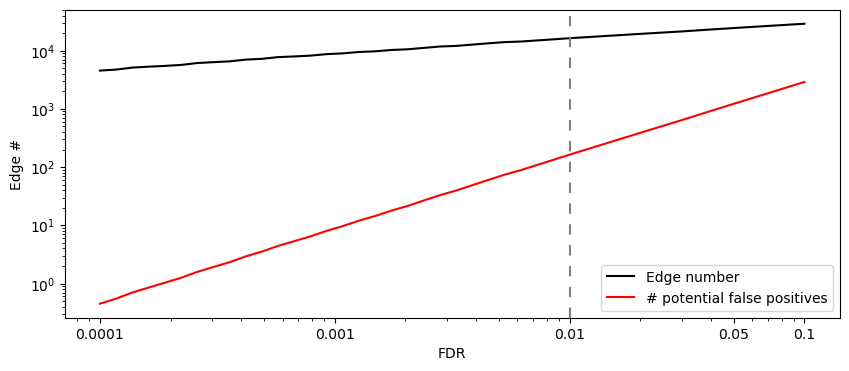

In [28]:
fdr_df=pd.DataFrame()
for fdr in np.append(np.geomspace(1e-4, 0.01, 30), [0.02, 0.03, 0.04, 0.05,0.1]):
    out=pd.Series([fdr,(PRmatrix.Padj<fdr).sum(),np.round(fdr*((PRmatrix.Padj<fdr).sum()),2)],
                  index=['FDR','num_edges','num_fp'])
    fdr_df=pd.concat([fdr_df, out], axis=1)
fdr_df=fdr_df.T
    
fig,ax=plt.subplots(figsize=(10,4))
sns.lineplot(data=fdr_df, x='FDR', y='num_edges', color='black', ax=ax, label='Edge number')
sns.lineplot(data=fdr_df, x='FDR', y='num_fp', color='red', ax=ax, label='# potential false positives')
ax.set(xscale='log', yscale='log', ylabel='Edge #');
ax.set_xticks([1e-4,1e-3, 1e-2, 1e-1, 0.05])
ax.set_xticklabels([1e-4,1e-3, 1e-2, 1e-1, 0.05])
ax.axvline(0.01, dashes=[0,0,5,5], color='gray');

Note how the number of potential false positives increases substantially with the number of edges, showing that networks with large sizes can have a high number of false positives. Thus, selecting an appropriate cut-off needs to take into account these two quantities.  
By being more conservative, one will be more sure of the identified associations but a network that is too small may miss biologically important associations (i.e. have many false negatives) and become too sparse to be representative of the biology. This may result in very small communities of nodes, and many dyads and isolated vertices. On the other hand, a network that is too big may display a very high number of associations that are not observed biologically (false positives). It is likely that such networks will display large communities and high density. Think of the balance between [Type I and Type II errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors#Type_I_error). Unfortunately, because this is an unsupervised problem we have no way to compute the false negative rate. This is not always the case: if you are dealing with human proteomics, one possible solution to identify false negatives can be from using a [reference map of human protein-protein interactions](https://www.nature.com/articles/s41586-020-2188-x).

In choosing an appropriate cut-off we will thus rely on the number of potential false positives and the network dimensions. In another section below, we will compare different networks and explore how their structure differs both in network properties (e.g. [centrality](https://en.wikipedia.org/wiki/Centrality)) and [communities](https://en.wikipedia.org/wiki/Community_structure). Bear in mind that false positives should not have an extensive impact on the network communities if these spurious associations are randomly distributed throughout the network, since the community interrogation algorithms usually compute regions of high density. 

We will also look at how the statistically significant correlation coefficients change FDR.

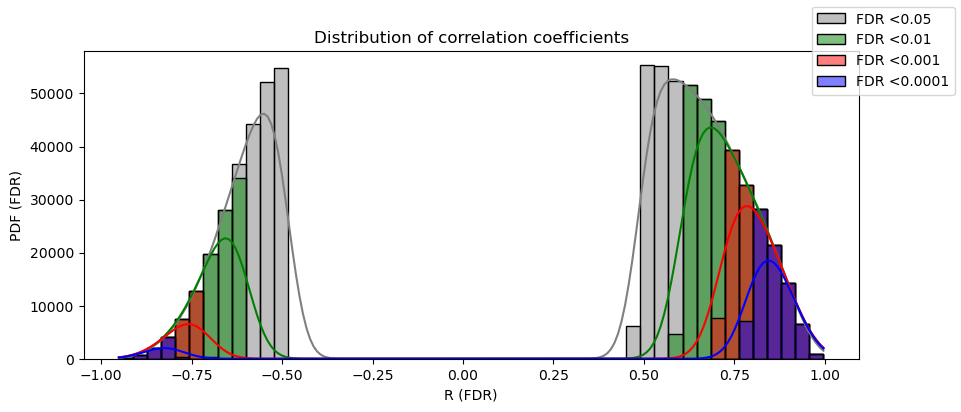

In [29]:
fig,ax=plt.subplots(figsize=(10,4))

for fdr in [0.05, 0.01, 0.001, 0.0001]:
    ## Plotting R distribution
    temp=PRmatrix.copy()
    temp.loc[:,'R (fdr)']=temp['R'].copy()
    temp.loc[temp['FDR']>fdr,'R (fdr)']=0
    
    temp=temp.loc[temp.feat1!=shortPR.feat2]
    
    color={0.05:'gray',0.01:'green',0.001:'red',0.0001:'blue'}[fdr]

    
    p=sns.histplot(
        temp['R (fdr)'][temp['R (fdr)']!=0], color=color, label='FDR <'+str(fdr), kde=True, ax=ax, bins=50);
    p.set(ylabel='PDF (FDR)')

fig.legend()
plt.xlabel('R (FDR)');
plt.title('Distribution of correlation coefficients');

Predicably, by being more conservative we will be selecting higher absolute correlation coefficients. In this test case we are considering only 25 samples. Larger sample sizes lead to lower nominal and adjusted p-values, and a higher number of statistically significant but milder correlation coefficients. In such cases, one may be more conservative in the significance threshold. Henceforth, we will consider as statistically significant those edges where FDR < 0.01.

One last point comes from the comparison of statistically significant associations within and between omics. Note how so few inter-omic associations are identified, and that Bonferroni correction completely misses any.

In [30]:
bonferroni_significant=PRmatrix.copy().loc[PRmatrix.Padj<0.01].loc[:,['feat1','feat2','R','int_type']]
bonferroni_significant['sig_test']='bonferroni'
fdr_significant=PRmatrix.copy().loc[PRmatrix.FDR<0.01].loc[:,['feat1','feat2','R','int_type']]
fdr_significant['sig_test']='FDR'

pd.concat([bonferroni_significant,fdr_significant]).groupby(['sig_test','int_type'])['R'].agg('count').reset_index()

,sig_test,int_type,R
0,FDR,gene_gene,398274
1,FDR,met_gene,118
2,FDR,met_met,3976
3,bonferroni,gene_gene,15434
4,bonferroni,met_met,871


### Questions

In building a graph from an association analysis:
- Why do you think that most significant correlations are found only within each omic? 
- How will you deal with the positive and negative sets of correlations above?
- Will you consider the network as weighted? Directed?
- Which dataset would you select for further analysis: the Bonferroni or the FDR-corrected? Why?
- What preliminary tests would you perform on the graph to assess whether node relationships are random?

# Network construction

We will now build 4 different networks to analyse further:
- A full association network filtered using FDR-corrected P values (<0.01). This is an unweighted network.
- The subset of positively associated features, where correlation coefficient is used as weight.
- kNN-G that we will generate from the expression profile. This will be unweighted.
- A random network based on the [Erdos-Renyi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), with the same node and edge number of each network. 

This will be a null-model for our analyses. The idea is that if a certain property found in one of our graphs is  reproduced in a random graph, then we do not need to account for any other possible explanations for that feature. In other words, if a property of a graph (e.g. clustering) is not found in a random network, we can assume that it does not appear in our biological network due to randomness.

In [32]:
# Prepares table for being read by igraph
PRmatrix=pd.read_csv('lab/data/serialization/association_matrix.tsv', sep="\t")
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0
PRmatrix=PRmatrix.loc[PRmatrix['R (fdr)']!=0,['feat1','feat2','R (fdr)']]
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2] #drops self correlations

fdr_pos_mat=PRmatrix.loc[PRmatrix['R (fdr)']>0]
fdr_neg_mat=PRmatrix.loc[PRmatrix['R (fdr)']<0]

#selects only nodes also found in the positive network so that we can compare networks of the same sizes
PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,]

We will now build the kNNG, using distances as input to determine the nearest neighbours. Because this data contains both gene expressions and metabolite quantifications, we need to normalize them beforehand. (We didn't need to do this above as we were comparing ranks)

We start by standardizing all features

In [33]:
PRmatrix.head()

,feat1,feat2,R (fdr)
8,C0_accarnitines,C10_accarnitines,0.659505
68,C0_accarnitines,PCaaC42_0_glycerophospholipids,0.722315
2130,C2_accarnitines,Arg_aminoacids,0.711304
2133,C2_accarnitines,His_aminoacids,0.633043
2139,C2_accarnitines,Thr_aminoacids_NORM,0.634783


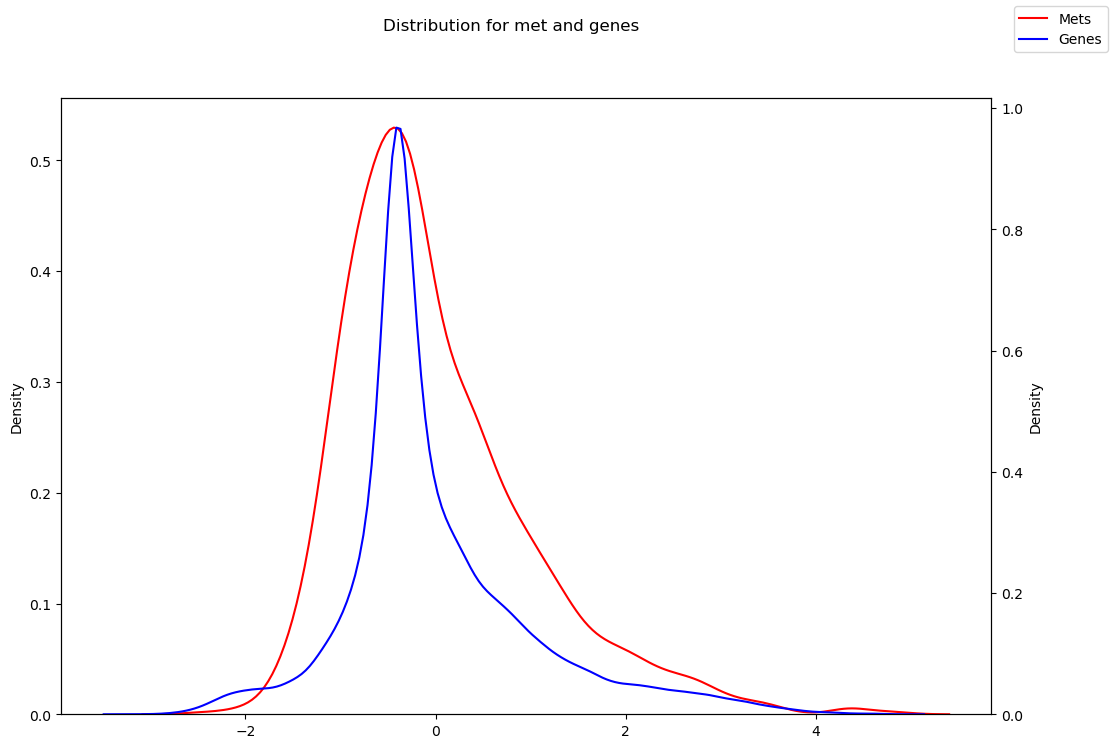

In [34]:
#Imports and normalizes met and gene data so that we can compute similarities between them
from sklearn.preprocessing import StandardScaler
data=pd.read_csv('lab/data/met_genes.tsv', sep="\t", index_col=0)

scaled_data=pd.DataFrame(StandardScaler().fit_transform(data.loc[:,data.columns!='Type'].T).T, columns=data.columns[data.columns!='Type'], index=data.index)
scaled_data_values=scaled_data.copy()
scaled_data['Type']=data.Type

#Plots the data distribution
fig,ax=plt.subplots(figsize=(12,8))
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='met',scaled_data.columns!='Type'].values.flatten(), 
    color='r', label='Mets', ax=ax, legend=False)
ax2=ax.twinx()
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='genes',scaled_data.columns!='Type'].values.flatten(),
    color='b', label='Genes', ax=ax2, legend=False)
fig.suptitle('Distribution for met and genes');
fig.legend();

In [35]:
input_ds=scaled_data_values.loc[scaled_data_values.index.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten()))]
input_ds.head()

,p10,p11,p12,p14,p15,p16,p18,p22,p23,p24,...,p37,p38,p4,p40,p41,p46,p48,p5,p8,p9
feature,,,,,,,,,,,,,,,,,,,,,
C0_accarnitines,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,4.302810,-0.283259,...,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,-0.283259,1.928896
C2_accarnitines,-1.091069,2.662663,-0.562089,-0.539787,-0.155881,-0.492225,0.665140,0.166774,2.820305,0.229534,...,-1.979012,-0.465146,0.301895,0.460770,-0.136651,-0.468992,-0.810965,-0.077043,-0.686711,0.267967
C3_accarnitines,-0.587155,-0.587155,-0.587155,-0.587155,0.849915,1.218743,2.132726,1.069064,2.937833,-0.587155,...,-0.587155,0.750857,-0.587155,-0.587155,-0.587155,-0.587155,-0.587155,-0.587155,-0.587155,1.022489
C5DC_C6OH_accarnitines,-0.194339,0.226924,-0.767866,0.272220,-0.716144,-0.424297,-0.270612,-0.231623,0.110276,-0.139779,...,4.317705,-0.796138,-0.240113,0.014363,-0.336595,0.446307,-0.609538,-0.021007,-0.371504,-0.694598
C5MDC_accarnitines,-0.577804,0.551881,-0.558374,0.344380,-0.556174,-0.397915,-0.199422,-0.504603,-0.086143,-0.057000,...,4.420350,-0.509324,-0.402203,-0.224593,-0.234445,-0.093442,-0.510458,0.256485,-0.386765,-0.651137


In [36]:
### Generating the kNN graph
#Computes a kNN adjacency matrix from the input dataset
#and prepares table for being read by igraph
from sklearn.neighbors import kneighbors_graph

knnG=kneighbors_graph(input_ds.values, 200, metric='euclidean')
knnG=pd.DataFrame(knnG.toarray(), columns=input_ds.index.copy(), index=input_ds.index.copy())  #adjacency matrix
knnG.index.name='gene1'
knnG.columns.name='gene2'
knnG=knnG.stack().reset_index().rename(columns={0:'Connectivity'})
knnG=knnG.loc[knnG['Connectivity']!=0]

In [37]:
knnG.head()

,gene1,gene2,Connectivity
1,C0_accarnitines,C2_accarnitines,1.0
2,C0_accarnitines,C3_accarnitines,1.0
7,C0_accarnitines,C10_accarnitines,1.0
10,C0_accarnitines,C16_accarnitines,1.0
11,C0_accarnitines,C18_accarnitines,1.0


In [38]:
input_ds.shape[0]

2102

We will now generate the graphs from the dataframes above

In [39]:
PRmatrix.to_csv('lab/data/serialization/PRmatrix.tsv', sep="\t", index=False)
fdr_pos_mat.to_csv('lab/data/serialization/fdr_pos_mat.tsv', sep="\t", index=False)
knnG.to_csv('lab/data/serialization/knnG.tsv', sep="\t", index=False)

## Graph and community study plots (from part 2 and 3)

### Centrality studies plots

In [6]:
import pandas as pd
import numpy as np
import scipy as sp

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import json
with open('data/serialization/degree_data.json', 'r') as file:
    degree_data = json.load(file)

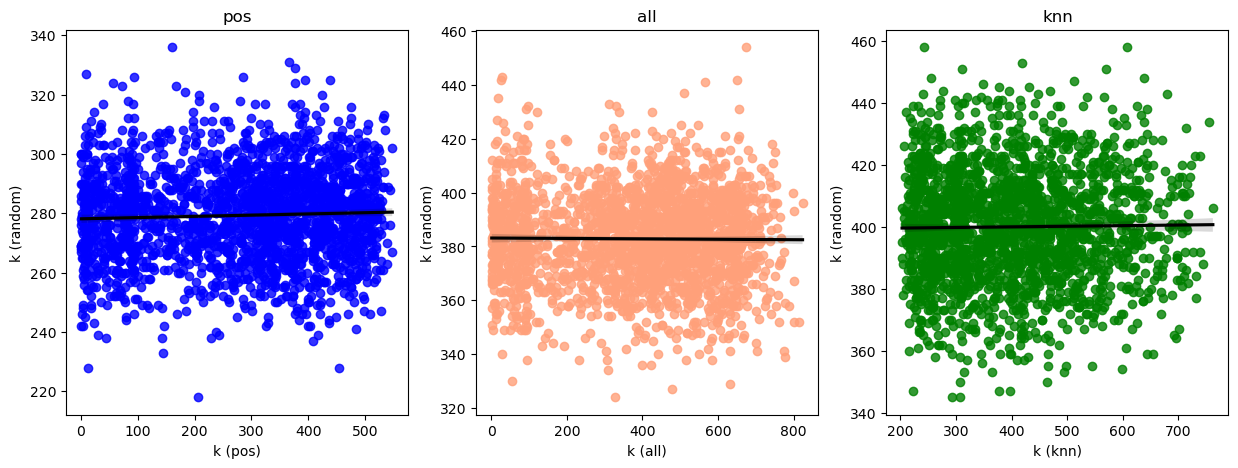

In [4]:
# RUN on: datasci env
import matplotlib.pyplot as plt

fig, axes=plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, ax in zip(range(4), axes.flat):
    x = [degree_data["degree_pos_w"], degree_data["degree_all_u"], degree_data["degree_knn"]]
    y = [degree_data["degree_random_posw"], degree_data["degree_random_allu"], degree_data["degree_random_knn"]]
    sns.regplot(x=x[i], y=y[i], 
                ax=ax, color=['blue','lightsalmon','green'][i],
               line_kws={'color':'black'}
               );
    ax.set_title(['pos','all','knn'][i])
    ax.set(xlabel='k ('+['pos','all','knn'][i]+')', ylabel='k (random)')

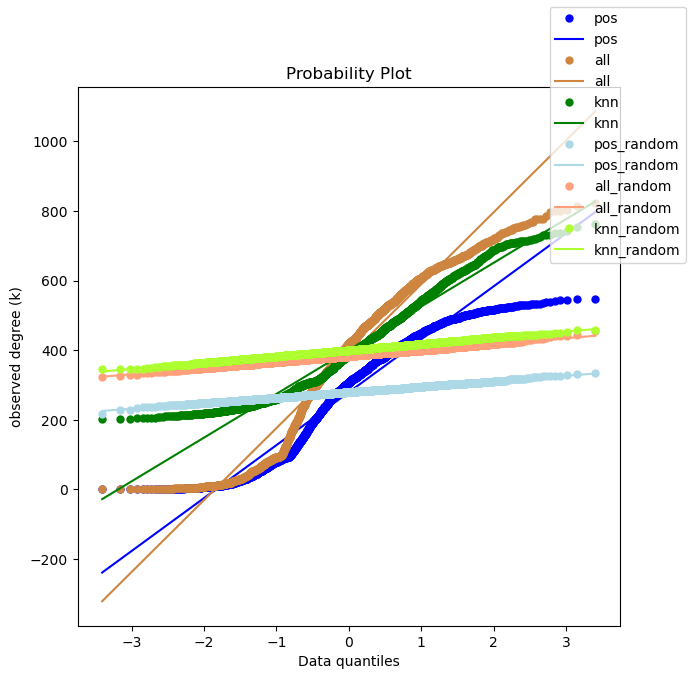

In [7]:
# RUN on: datasci env
"""
def transform_degree(graph):
    alldegs=graph.degree()
    alldegs=pd.DataFrame([[key,len(list(group))] for key,group in itertools.groupby(alldegs)], columns=['k','count'])
    alldegs['P(k)']=[x/alldegs['count'].sum() for x in alldegs['count']]
    alldegs=alldegs.loc[:,['k','P(k)']]
    alldegs.drop_duplicates(inplace=True)
    alldegs.reset_index(drop=True, inplace=True)
    return(alldegs)
"""

fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(degree_data["degree_pos_w"], plot=ax)
a=sp.stats.probplot(degree_data["degree_all_u"], plot=ax)
k=sp.stats.probplot(degree_data["degree_knn"], plot=ax)
r=sp.stats.probplot(degree_data["degree_random_posw"], plot=ax)
r2=sp.stats.probplot(degree_data["degree_random_allu"], plot=ax)
r3=sp.stats.probplot(degree_data["degree_random_knn"], plot=ax)

col=['blue','','peru','','green','','lightblue','','lightsalmon','','greenyellow','']
for x in np.arange(0,11,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos','pos','all','all','knn','knn','pos_random','pos_random','all_random','all_random','knn_random','knn_random']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.show()

In [9]:
network_centralities_raw = pd.read_csv("data/serialization/network_centralities_raw.csv", sep = "\t")

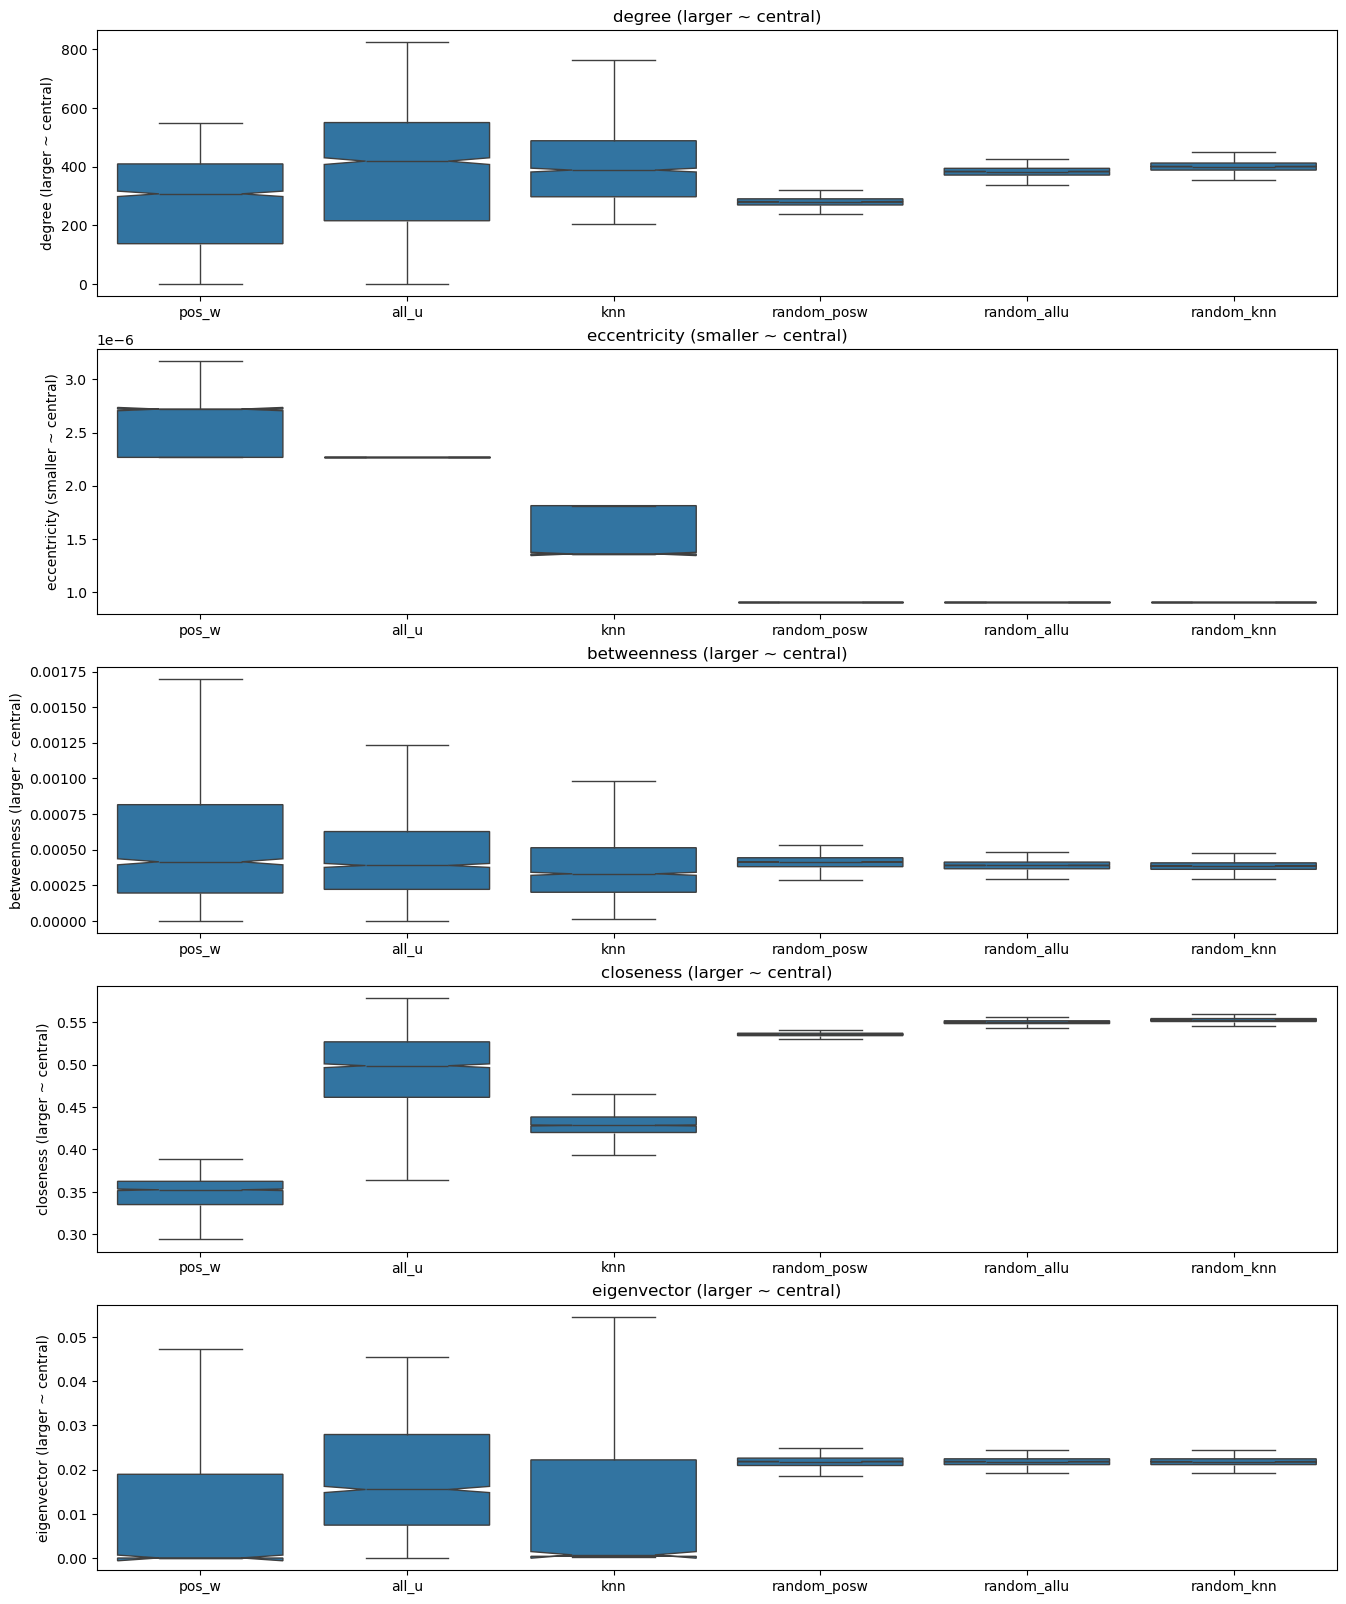

In [11]:
centralities_list=['degree (larger ~ central)','eccentricity (smaller ~ central)','betweenness (larger ~ central)', 'closeness (larger ~ central)','eigenvector (larger ~ central)']
fig, axes=plt.subplots(nrows=5, figsize=(16,20), sharey='row')
for i, ax in zip(range(6), axes.flat):
    sns.boxplot(
        data=network_centralities_raw, x='graph', y=centralities_list[i],  notch=True, ax=ax, showfliers=False)
    ax.set_title(centralities_list[i])
    ax.set(xlabel='')

When interpreting the results above, it is important to bear in mind that these networks have different network sizes.

Overall, we see:
- The median degree centrality decreases from `Full network > kNNG >  Positive assoc. network`.
- The median betweenness centrality tends to decrease from `Positive assoc. network > Full network > kNNG`.
- The median closeness centrality  tends to decrease from `Full network > kNNG > Positive assoc. network`.
- The eccentricity is very homogeneous for the `Full network (all_u)`, and slightly lower than in the `Full network`. In turn, most nodes in the `kNNG` tend to display an eccentricity of 3-4.


### Questions:
- Can you explain these observations?
- Based on the plots above, which graphs do you think follow a [*small world*](https://en.wikipedia.org/wiki/Small-world_network) behavior?

We will also explore the relationships between different centrality metrics. Because these have different interpretations, we will compute ranks for each centrality, and perform the correlations on the ranks. In the following cell we do this, and then compute correlations within the 5 metrics for the full network. One additional column is presented (`median_centrality`), that is basically the median of the ranks of the 5 other centralities. 

In [12]:
all_u_centcorr = pd.read_csv("data/serialization/all_u_centcorr.csv", sep = "\t", index_col = 0)
knn_centcorr = pd.read_csv("data/serialization/knn_centcorr.csv", sep = "\t", index_col = 0)
pos_w_centcorr = pd.read_csv("data/serialization/pos_w_centcorr.csv", sep = "\t", index_col = 0)

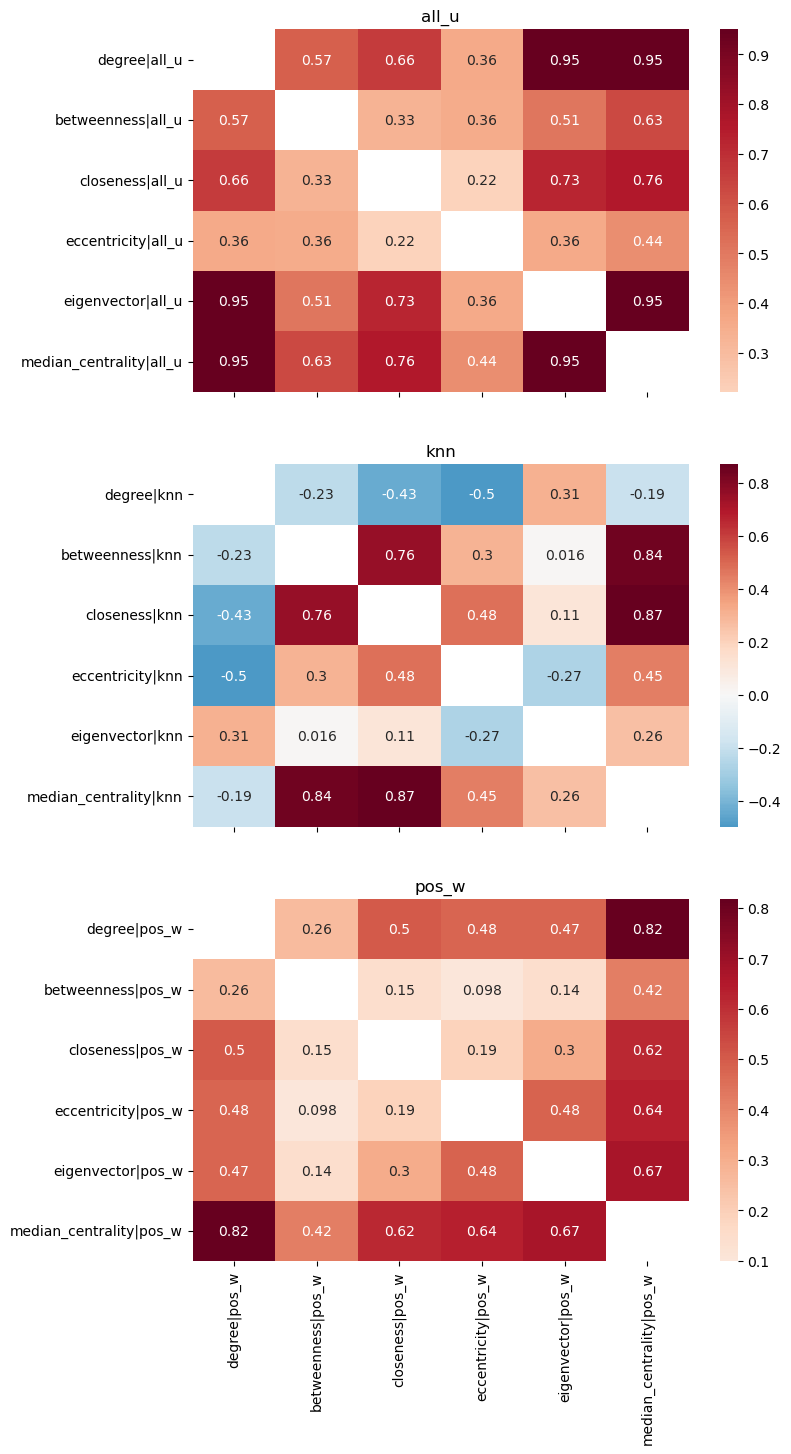

In [13]:
# RUN on: datasci env
fig,ax=plt.subplots(nrows=3, figsize=(8,16), sharex=True)
ax=ax.flatten()
for i in range(3):
    tdata=[all_u_centcorr,knn_centcorr, pos_w_centcorr][i]
    tname=['all_u','knn','pos_w'][i]
    sns.heatmap(tdata, cmap="RdBu_r", center=0, annot=True, ax=ax[i]);
    ax[i].set(title=tname)

The plot above shows that most of the centrality metrics are positively correlated in the full network and in the positively coexpression network. However, this is not the case for the KNN network.

#### Questions

1. How do you explain the inverse relationship between degree and most other metrics in the KNN network?
2. Why do you think that the KNN network specifically displays this opposite trend?

The next figure may help in answering the question above. We highlight the most central nodes based on degree (red) and eccentricity (green), in addition to a random subset of 500 nodes. Of these, which do you think displays the shortest path to all other nodes?

### Community studies plots

In [15]:
feat_lists = pd.read_csv("data/serialization/feat_lists.csv", sep = "\t")
comm_counts = pd.read_csv("data/serialization/comm_counts.csv", sep = "\t", index_col = 0)

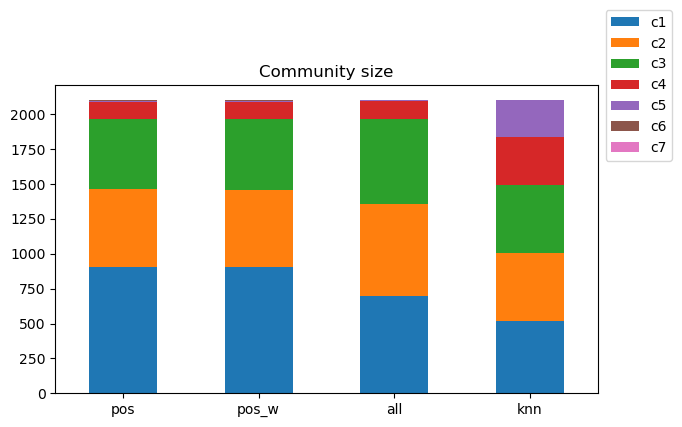

In [16]:
# RUN on: datasci env

#Plotting community sizes
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 4))
bar_data=comm_counts.fillna(0).T
bar_data.plot(kind='bar', stacked=True, ax=ax);
# ## number of communities in each
# for index, row in groupedvalues.iterrows():
#     g.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")
ax.legend(comm_counts.index, loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

Some of the communities are very small in the `pos` and full networks, and comprise only 2 and 3 elements. Can we really call this a community?

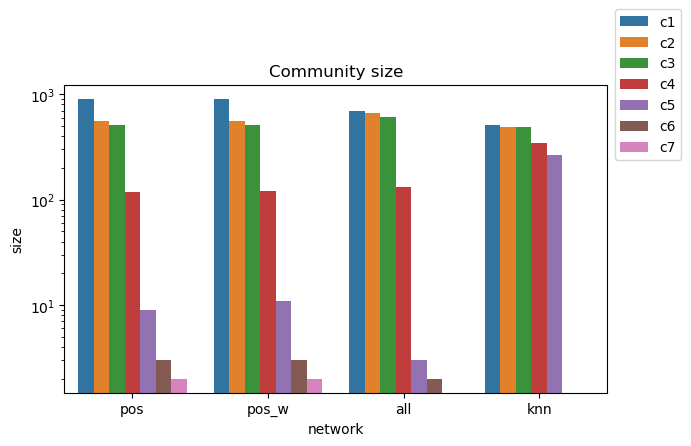

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=bar_data.T.unstack().reset_index().rename(columns={'level_0':'network','level_1':'community',0:'size'}),
    x='network',y='size', hue='community'
           )

ax.set(yscale='log');
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

### Annotation studies plots

In [18]:
enriched_terms = pd.read_csv("data/serialization/enriched_terms.csv", sep = "\t", index_col = 0)

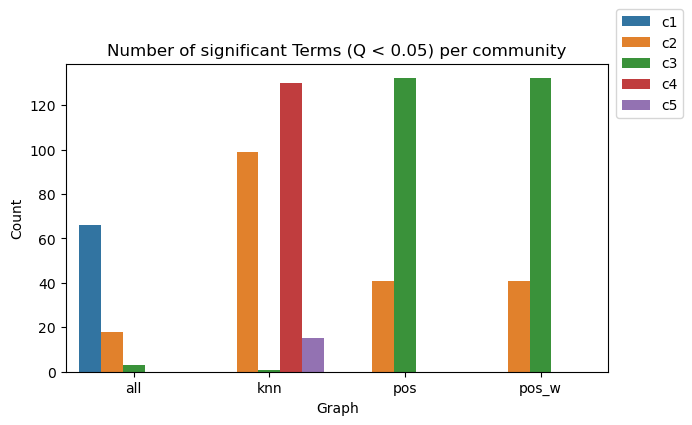

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))
data_bars=pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count')).stack().reset_index().rename(columns={0:'Count'})
sns.barplot(x='Graph', y='Count', data=data_bars, hue='Comm')
ax.set_title('Number of significant Terms (Q < 0.05) per community')
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
plt.xticks(rotation=0)
plt.show()